
# Project Overview & Objectives

The goal of this project is to explore whether the tone of financial news articles is linked to movements in the NASDAQ index. The core idea is to understand whether shifts in media sentiment can reflect or even anticipate changes in the stock market.

To investigate this, I collected financial headlines from three major sources: *CNBC*, *Reuters*, and *The Guardian*. When descriptions were missing, I used a language model to generate short summaries, creating a more complete textual dataset. Each headline + description pair was then scored for sentiment using pre trained NLP models from Hugging Face.

These sentiment scores were aggregated on a monthly level and aligned with the monthly average closing values of the NASDAQ index (retrieved via `yfinance`). This gave me two synchronized time series: one for public sentiment, and one for actual market performance.

To assess whether sentiment could help forecast market trends, I compared two models:

* A simple linear regression, using sentiment scores to predict the NASDAQ.
* A SARIMAX time series model, which incorporates both past NASDAQ behavior and sentiment as an external signal.

The purpose was not just to build a predictive model, but to examine whether language in the financial press holds explanatory or predictive value when it comes to market behavior  and how combining NLP with time series modeling can provide meaningful insights into investor psychology.



# Data Acquisition & Initial Inspection

In the first step, I downloaded the **Financial News Headlines** dataset from Kaggle (https://www.kaggle.com/datasets/notlucasp/financial-news-headlines). This dataset aggregates news headlines scraped directly from the official websites of CNBC, Reuters and The Guardian, covering the period from late December 2017 to July 19, 2020.

I then loaded the three CSV files `cnbc_headlines.csv`, `reuters_headlines.csv` and `guardian_headlines.csv` into pandas DataFrames. In the CNBC and Reuters files, each record includes a publication timestamp (`Time`), the headline text (`Headlines`) and a brief preview description (`Description`). The Guardian file contains only the timestamp and headline text, since no preview field is available.

This assembled corpus provides a time stamped record of U.S. business and economic news, ideal for sentiment analysis, topic modeling or integrating with market indices (e.g., NASDAQ) to build forecasting models.


In [ ]:
!pip install transformers==4.28.1
!pip install datasets
!pip install huggingface_hub
!pip install yfinance
!pip install ruptures
!pip install torch
!pip install ruptures


In [ ]:
from huggingface_hub import login

login()

# Environment Setup & Authentication

In the second step, I opened a **Google Colab** notebook and installed all necessary Python libraries `transformers` (v4.28.1), `datasets`, `huggingface_hub`, `yfinance`, `ruptures`, and `torch` using `pip`. Then, after registering and obtaining an access token in the Hugging Face community portal, I ran:

```python
from huggingface_hub import login
login()


In [ ]:
from datasets import Dataset
from transformers import pipeline
import pandas as pd
import torch

# Use the more capable GPT-2  model via Hugging Face pipeline
generator = pipeline(
    "text-generation",
    model="gpt2",
    device=0 if torch.cuda.is_available() else -1,
    pad_token_id=50256                      # Needed to avoid warning about missing pad token
)

# Load your dataset of Guardian headlines
guardian_df = pd.read_csv("/content/guardian_headlines.csv")
guardian_df = guardian_df[guardian_df["Headlines"].notnull()].copy()
guardian_ds = Dataset.from_pandas(guardian_df)

# Define a simple batch generation function
def generate_descriptions(batch):
    prompts = [
        f"This is a financial news headline: '{headline}'. Write a short description of the event as a financial journalist:"
        for headline in batch["Headlines"]
    ]

    results = generator(
        prompts,
        max_new_tokens=25,
        do_sample=True,
        temperature=1.0,
        top_p=0.90
    )

    batch["generated_description"] = [
        r[0]["generated_text"].split(":")[-1].strip() for r in results
    ]
    return batch

# Apply the function in batches
guardian_ds = guardian_ds.map(
    generate_descriptions,
    batched=True,
    batch_size=1024
)
# Save results
guardian_ds.to_pandas().to_csv("/content/guardian_with_descriptions_gpt2.csv", index=False)


Device set to use cuda:0


Map:   0%|          | 0/17800 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


# Augmenting Missing Descriptions via LLM

In this step, I noticed that the Guardian dataset one of the three **news outlets** (CNBC, Reuters, and The Guardian) lacked a `Description` field. To balance the data across all news outlets, I generated synthetic summaries using Hugging Face’s GPT-2 model. Each headline was batched and fed into the `text-generation` pipeline (`model="gpt2"`, `temperature=1.0`, `top_p=0.9`) to produce up to 25 new tokens. The resulting text was appended as a new `generated_description` column, and I verified that the generated descriptions were coherent before saving the augmented DataFrame to CSV.



In [ ]:
from transformers import pipeline
import pandas as pd
from datasets import Dataset

# Load sentiment model
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Load original datasets
guardian = pd.read_csv("/content/guardian_headlines.csv")
guardian["source"] = "Guardian"
guardian["is_synthetic"] = False

reuters = pd.read_csv("/content/reuters_headlines.csv")
reuters["source"] = "Reuters"
reuters["is_synthetic"] = False

cnbc = pd.read_csv("/content/cnbc_headlines.csv")
cnbc["source"] = "CNBC"
cnbc["is_synthetic"] = False

# Load synthetic Guardian data (generated with GPT)
guardian_synth = pd.read_csv("/content/guardian_with_descriptions_gpt2.csv")
guardian_synth["source"] = "Guardian"
guardian_synth["is_synthetic"] = True

# Combine all data
df_all = pd.concat([guardian, reuters, cnbc, guardian_synth], ignore_index=True)

# Build full input from headline and optional description
df_all["full_input"] = df_all.apply(
    lambda row: f"{row['Headlines']}. {row['generated_description']}" if "generated_description" in row and pd.notnull(row["generated_description"]) else row["Headlines"],
    axis=1
)

# Drop empty or null rows
df_all = df_all[df_all["full_input"].notnull() & df_all["full_input"].str.strip().ne("")].copy()

# Convert to Hugging Face Dataset
ds = Dataset.from_pandas(df_all)

# Sentiment scoring function
def score_batch(batch):
    results = classifier(batch["full_input"])
    scores = [float(r["label"].split()[0]) * 2.0 for r in results]  # Normalize 1–5 stars → 2–10 scale
    batch["sentiment_score_1_to_10"] = scores
    return batch

# Apply model in batches
ds = ds.map(score_batch, batched=True, batch_size=64)

# Save to final CSV
ds.to_pandas().to_csv("/content/news_all_sources_sentiment_mixed.csv", index=False)


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Map:   0%|          | 0/71170 [00:00<?, ? examples/s]

# NLP Sentiment Scoring of Combined Headlines

In Step 4 I applied a pretrained **NLP sentiment‐analysis model** (`nlptown/bert-base-multilingual-uncased-sentiment`) to assign a numeric mood score to every headline in our dataset. First, I loaded the original CSVs for CNBC, Reuters and The Guardian—tagging each row with its `source` and marking `is_synthetic = False`and then brought in the GPT-2–generated Guardian file (`guardian_with_descriptions_gpt2.csv`), tagged as `is_synthetic = True` to indicate its synthetic summaries.

Next, I merged all four DataFrames into one master table and created a `full_input` field. Whenever a synthetic description was available, I concatenated it with the original headline so the model would have both the title and context; otherwise I passed only the headline. I also removed any empty or whitespace‐only entries to ensure clean text for the NLP pipeline.

I then converted this pandas DataFrame into a Hugging Face `Dataset` for efficient batching and called the `pipeline("sentiment-analysis")` in batches of 64 records. The model returned a 1–5 star label for each input, which I multiplied by 2.0 to normalize into a finer 2–10 scale. These sentiment scores were appended as a new `sentiment_score_1_to_10` column.

Finally, I exported the fully scored dataset to `news_all_sources_sentiment_mixed.csv`, ready for downstream analysis, visualization or integration into forecasting models.  



Dropped 0 rows out of 71170 total (0.00%) due to invalid date format.


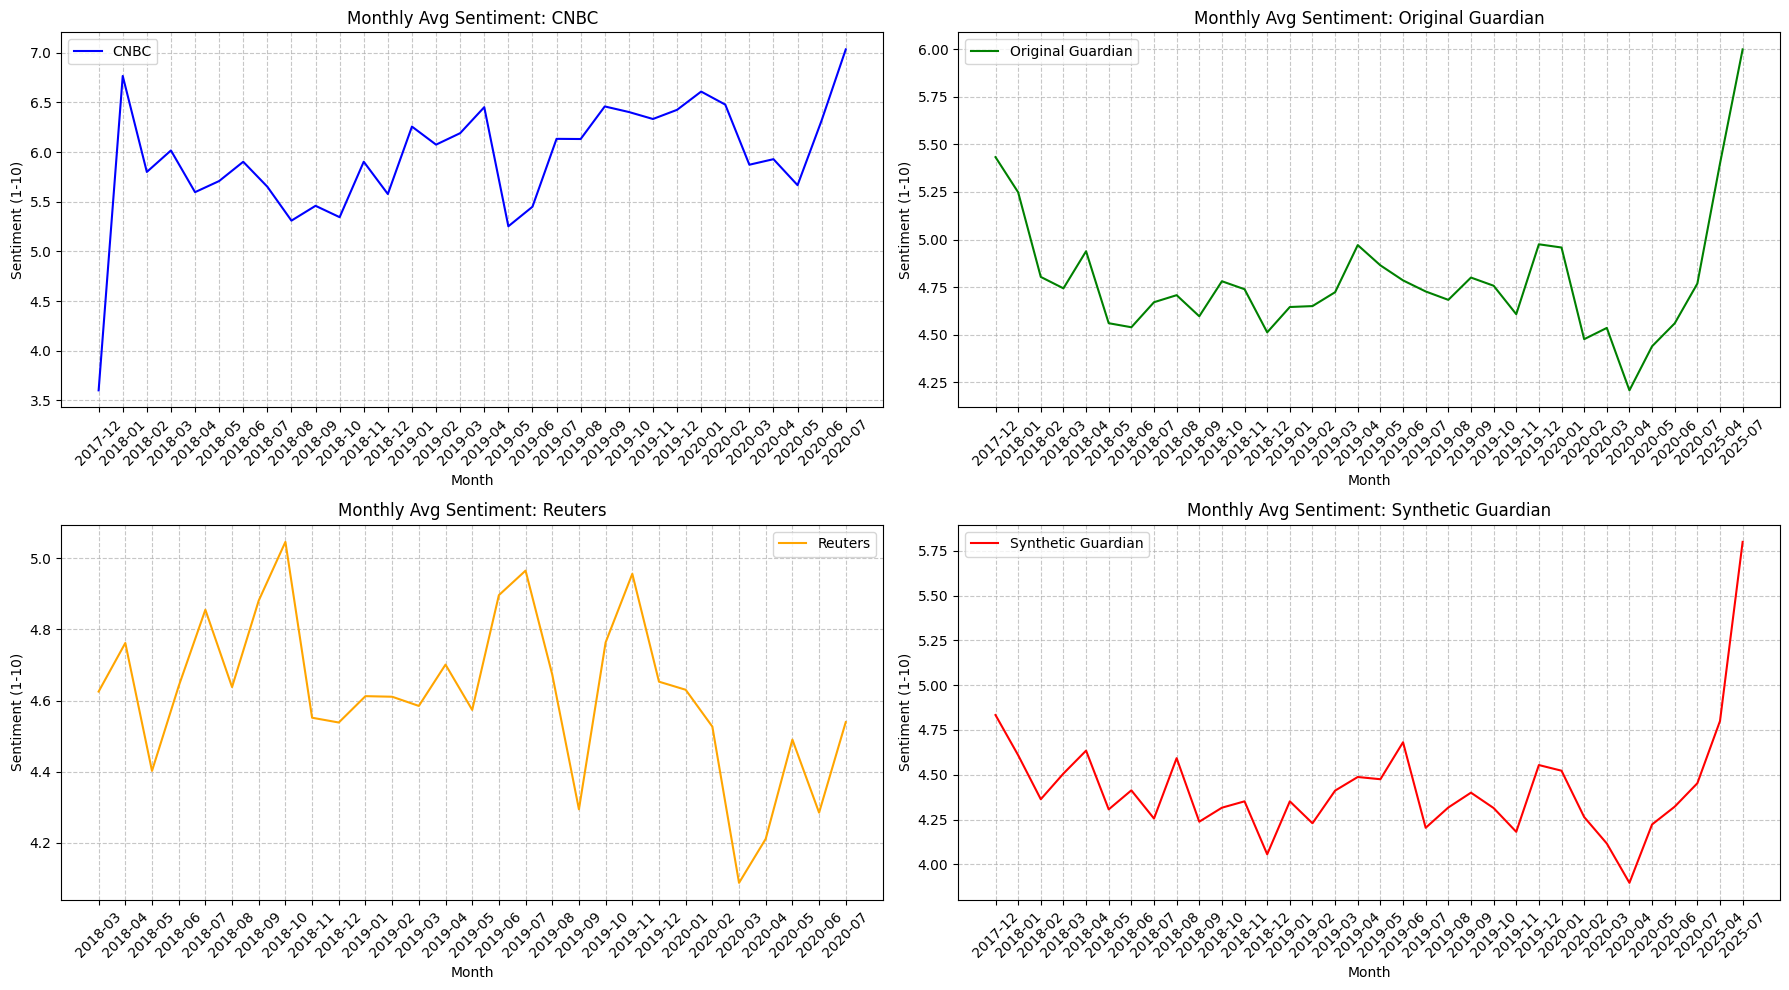

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

# Load the dataset
df = pd.read_csv("/content/news_all_sources_sentiment_mixed.csv", low_memory=False)

# Step 1: Clean 'Time' column manually by removing known suffixes and trimming
df["Time_cleaned"] = (
    df["Time"]
    .astype(str)
    .str.replace(r"\b(ET|EST|EDT|CT|CST|PST|GMT|UTC|AM|PM)\b", "", regex=True)
    .str.replace(r"[^a-zA-Z0-9\s:/\-]", "", regex=True)
    .str.strip()
)

# Step 2: Define manual parser that tries dateutil parsing
def try_parse_date_manual(text):
    try:
        return parser.parse(text, dayfirst=False, yearfirst=False, fuzzy=True)
    except Exception:
        return pd.NaT

# Step 3: Apply date parsing
df["ParsedTime"] = df["Time_cleaned"].apply(try_parse_date_manual)

# Step 4: Drop rows with invalid dates
initial_len = len(df)
df = df.dropna(subset=["ParsedTime"])
dropped_rows = initial_len - len(df)
print(f"Dropped {dropped_rows} rows out of {initial_len} total ({(dropped_rows / initial_len) * 100:.2f}%) due to invalid date format.")

# Step 5: Create month column
df["month"] = df["ParsedTime"].dt.to_period("M").astype(str)

# Step 6: Normalize source and synthetic flag
df["source_clean"] = df["source"].astype(str).str.strip()
df.loc[df["is_synthetic"] == True, "source_clean"] = "Synthetic GPT Guardian"
df.loc[(df["is_synthetic"] == True) & (df["source_clean"].str.lower().str.contains("guardian")), "source_clean"] = "Synthetic Guardian"
df.loc[(df["is_synthetic"] != True) & (df["source_clean"].str.lower().str.contains("guardian")), "source_clean"] = "Original Guardian"

# Step 7: Group by source and month to compute monthly average sentiment
grouped = df.groupby(["source_clean", "month"])["sentiment_score_1_to_10"].mean().reset_index()

# Step 8: Plot 4 subplots
sources = grouped["source_clean"].unique()
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
colors = ["blue", "green", "orange", "red"]
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, source in enumerate(sources):
    if i >= 4:
        break
    ax = axs[positions[i][0]][positions[i][1]]
    data = grouped[grouped["source_clean"] == source]
    ax.plot(data["month"], data["sentiment_score_1_to_10"], label=source, color=colors[i])
    ax.set_title(f"Monthly Avg Sentiment: {source}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Sentiment (1-10)")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

# Hide unused subplot if fewer than 4 sources
if len(sources) < 4:
    ax = axs[positions[len(sources)][0]][positions[len(sources)][1]]
    ax.axis("off")

plt.tight_layout()
plt.show()


# Time Parsing, Aggregation & Visualization

In Step 5 I parsed and cleaned the raw timestamp strings by removing timezone suffixes and stray characters, then converted them into datetime objects. Any rows that failed parsing were dropped. From each valid datetime I extracted a “YYYY/MM” month field. I standardized the source labels into four categories CNBC, Reuters, Original Guardian and Synthetic Guardian so that each record indicates where it came from and whether its description was synthetic.

Next, I grouped the data by source and month to calculate the average 2–10 sentiment score for each combination. These monthly averages were plotted in a 2×2 grid of line charts, one subplot per source. Each chart includes a title, axis labels, rotated x-axis ticks for readability, and dashed gridlines for clarity.

**Graph Interpretation**

In the CNBC chart the sentiment line climbs from about 5.5 in early 2018 up to roughly 7.0 by mid-2020, with a noticeable dip around March–April 2020 during the pandemic before rebounding strongly.

The Original Guardian plot begins near 5.4 in December 2017, falls into the high 4 range through 2018–2019, drops to about 4.2 in March 2020 and then surges to around 6.0 in July 2020, showing a dramatic mid pandemic shift in tone.

Reuters remains the most stable, fluctuating between 4.5 and 4.8 over 2018–2019, dipping to about 4.1 in March 2020 and recovering modestly by mid 2020.

The Synthetic Guardian line closely follows the Original Guardian pattern but with slightly larger swings falling as low as 3.9 in April 2020 and rising to about 5.8 in July 2020 demonstrating that the GPT-2 generated summaries preserved the overall sentiment trends with a bit more volatility.



Dropped 0 rows out of 71170 total (0.00%) due to invalid date format.


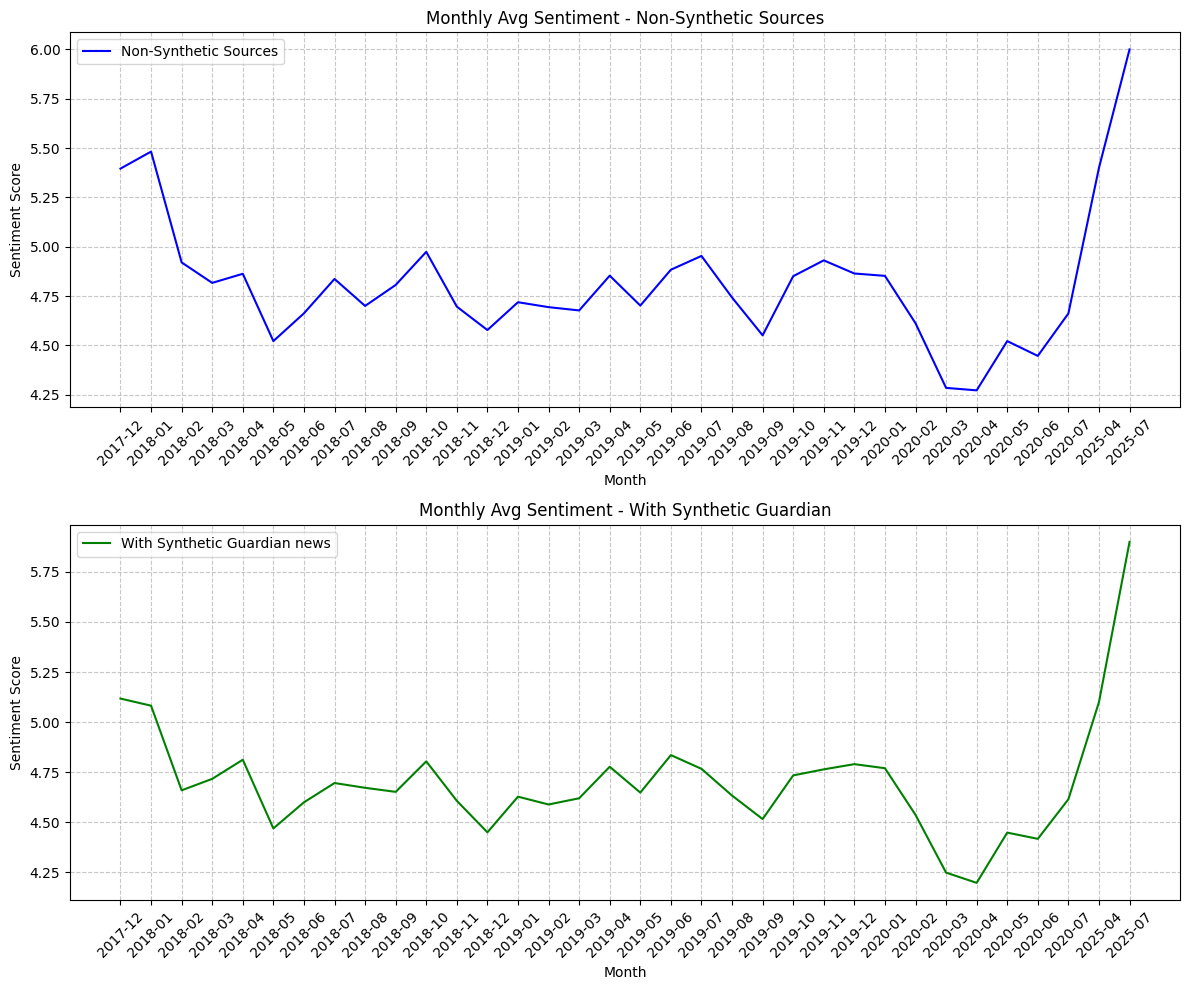

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

# Load dataset
df = pd.read_csv("/content/news_all_sources_sentiment_mixed.csv", low_memory=False)

# Step 1: Clean 'Time' column manually by removing known suffixes and trimming
df["Time_cleaned"] = (
    df["Time"]
    .astype(str)
    .str.replace(r"\b(ET|EST|EDT|CT|CST|PST|GMT|UTC|AM|PM)\b", "", regex=True)
    .str.replace(r"[^a-zA-Z0-9\s:/\-]", "", regex=True)
    .str.strip()
)

# Step 2: Define manual parser that tries dateutil parsing
def try_parse_date_manual(text):
    try:
        return parser.parse(text, dayfirst=False, yearfirst=False, fuzzy=True)
    except Exception:
        return pd.NaT

# Step 3: Apply date parsing
df["ParsedTime"] = df["Time_cleaned"].apply(try_parse_date_manual)

# Step 4: Drop rows with invalid dates
initial_len = len(df)
df = df.dropna(subset=["ParsedTime"])
dropped_rows = initial_len - len(df)
print(f"Dropped {dropped_rows} rows out of {initial_len} total ({(dropped_rows / initial_len) * 100:.2f}%) due to invalid date format.")

# Step 5: Create month column
df["month"] = df["ParsedTime"].dt.to_period("M").astype(str)

# Step 6: Normalize source and synthetic flag
df["source_clean"] = df["source"].astype(str).str.strip()
df.loc[df["is_synthetic"] == True, "source_clean"] = "Synthetic GPT Guardian"
df.loc[(df["is_synthetic"] == True) & (df["source_clean"].str.lower().str.contains("guardian")), "source_clean"] = "Synthetic Guardian"
df.loc[(df["is_synthetic"] != True) & (df["source_clean"].str.lower().str.contains("guardian")), "source_clean"] = "Original Guardian"

# Step 7: Filter data for the two groups
non_synthetic_sources = df[df["is_synthetic"] != True]
synthetic_guardian_plus = df[
    (df["source_clean"].isin(["Original Guardian", "Synthetic Guardian"])) |
    ((df["is_synthetic"] != True) & (~df["source_clean"].str.contains("Guardian")))
]

# Step 8: Group by month and calculate mean
monthly_non_synthetic = non_synthetic_sources.groupby("month")["sentiment_score_1_to_10"].mean()
monthly_synthetic_plus = synthetic_guardian_plus.groupby("month")["sentiment_score_1_to_10"].mean()

# Step 9: Plot both graphs
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].plot(monthly_non_synthetic.index, monthly_non_synthetic.values, color='blue', label='Non-Synthetic Sources')
axs[0].set_title("Monthly Avg Sentiment - Non-Synthetic Sources")
axs[0].set_xlabel("Month")
axs[0].set_ylabel("Sentiment Score")
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True, linestyle='--', alpha=0.7)

axs[0].legend()

axs[1].plot(monthly_synthetic_plus.index, monthly_synthetic_plus.values, color='green', label='With Synthetic Guardian news')
axs[1].set_title("Monthly Avg Sentiment - With Synthetic Guardian")
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Sentiment Score")
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].legend()

plt.tight_layout()
plt.show()




# Comparative Monthly Sentiment Trends

In Step 6 I reused the cleaned and timestamp‐parsed DataFrame to compare two groupings:  
- **Non-Synthetic Sources:** all headlines and descriptions originally scraped from CNBC, Reuters and The Guardian.  
- **With Synthetic Guardian News:** the same original set plus the GPT-2–generated Guardian summaries.

First, I filtered the DataFrame into those two subsets, then grouped each by its “YYYY-MM” month and calculated the average 2–10 sentiment score. Finally, I plotted them as two separate line charts in a single figure:

- The top chart shows how the mean sentiment of purely non-synthetic news evolves month by month.  
- The bottom chart overlays the same months but includes the synthetic Guardian descriptions, so you can see how augmentation shifts the aggregate sentiment.


## Graph Interpretation

**Non-Synthetic Sources (top, blue)**  
The line starts around **5.4** in Dec 2017, dips into the **4.8–5.0** range through mid-2018, then oscillates around **4.7–4.9** until a clear **pandemic trough** at **~4.3** in Mar 2020. After April 2020 it recovers steadily, climbing back to **6.0** by July 2020.

**With Synthetic Guardian (bottom, green)**  
Including the GPT-2 Guardian summaries shifts the early average slightly downward (starting ~5.1 vs. 5.4) and softens some peaks—e.g., the mid-2018 high is around **4.8** instead of **5.0**. The pandemic dip still occurs in Mar 2020 (to ~4.2), and the rebound reaches ~5.9 by July 2020. Overall, the synthetic data preserves the same **dip-and-rebound** pattern but marginally **dampens volatility** in the aggregate.




[*********************100%***********************]  1 of 1 completed


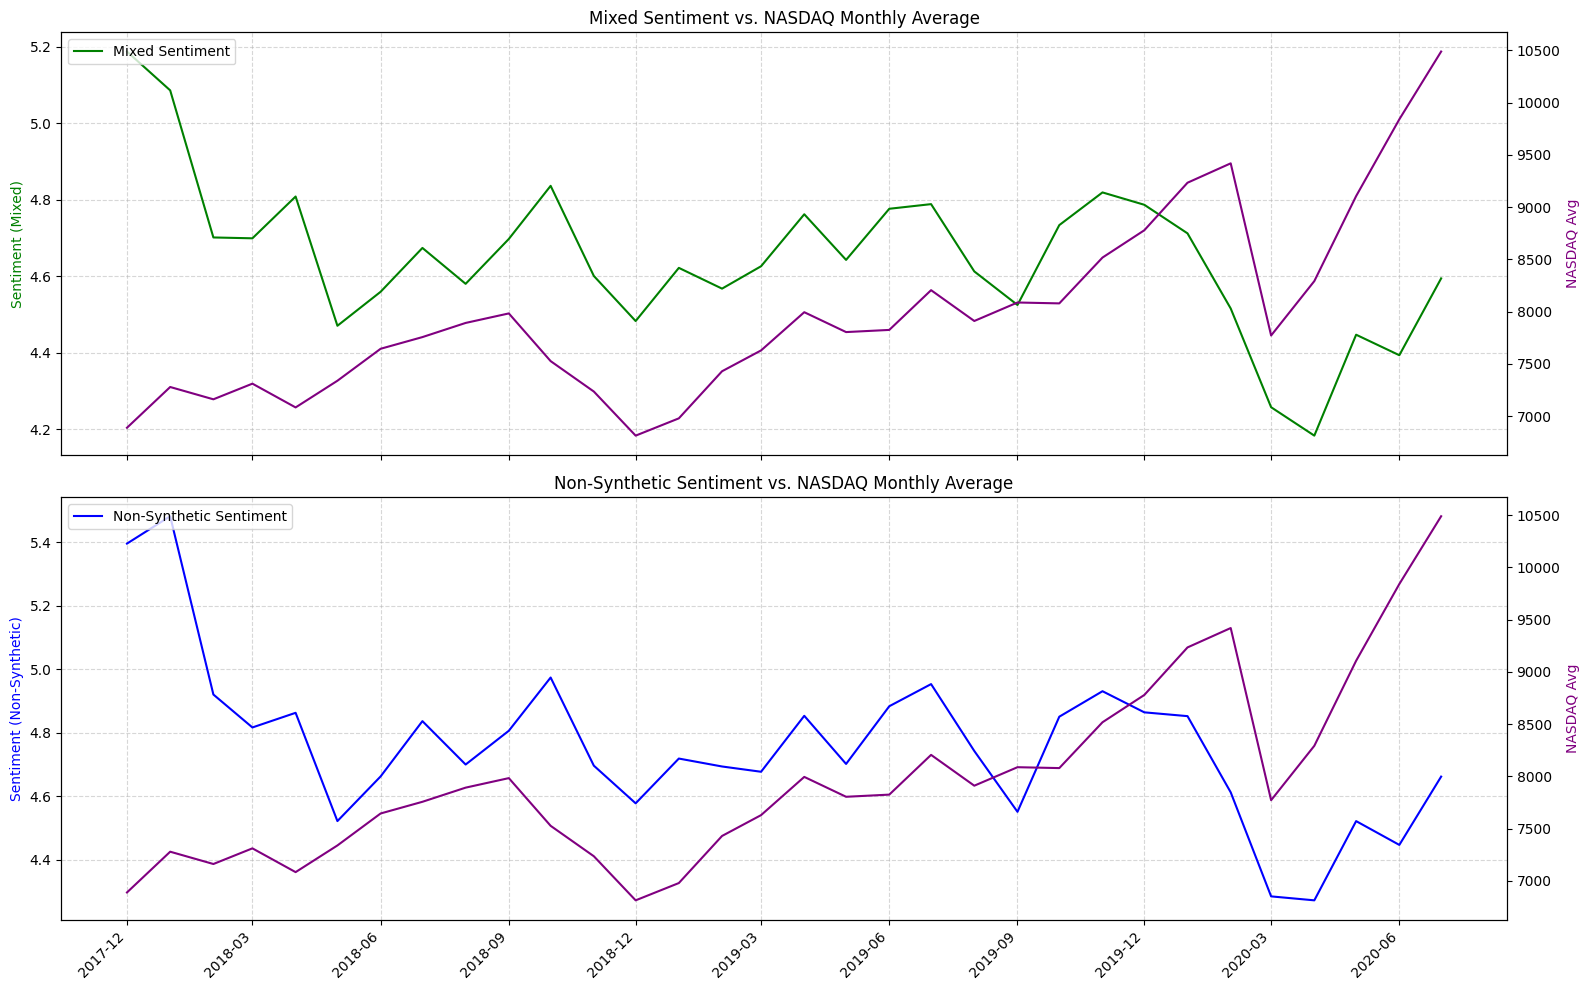

An important note ---->
Data has been filtered to include only months from Dec 2017 to July 2020.
This avoids artificial outliers caused by missing months after 2020,
which would otherwise create misleading spikes in the sentiment trends.
Both subplots now use a 3-month interval locator and rotated, right-aligned labels for clarity.


In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Step 1: Load sentiment datasets
mixed = pd.read_csv("/content/monthly_sentiment_mixed.csv")
non_synthetic = pd.read_csv("/content/monthly_sentiment_non_synthetic.csv")

# Step 2: Filter sentiment data to include only up to July 2020
mixed = mixed[mixed["month"] <= "2020-07"]
non_synthetic = non_synthetic[non_synthetic["month"] <= "2020-07"]

# Step 3: Download NASDAQ daily data and compute monthly averages
nasdaq = yf.download("^IXIC", start="2017-12-01", end="2020-07-31", interval="1d", auto_adjust=True)
nasdaq = nasdaq.reset_index()
nasdaq["month"] = nasdaq["Date"].dt.to_period("M").astype(str)
nasdaq_monthly = nasdaq.groupby("month")["Close"].mean().reset_index()
nasdaq_monthly.columns = ["month", "nasdaq_avg"]

# Step 4: Merge NASDAQ monthly averages into sentiment datasets
mixed_merged = pd.merge(mixed, nasdaq_monthly, on="month", how="left")
non_synthetic_merged = pd.merge(non_synthetic, nasdaq_monthly, on="month", how="left")

# Step 5: Convert 'month' to datetime for plotting
mixed_merged["month"] = pd.to_datetime(mixed_merged["month"])
non_synthetic_merged["month"] = pd.to_datetime(non_synthetic_merged["month"])

# Step 6: Plot graphs with dual Y-axes and formatted X-axis
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Top plot: Mixed sentiment vs NASDAQ
ax1 = axes[0]
ax1.plot(mixed_merged["month"], mixed_merged["sentiment"], color="green", label="Mixed Sentiment")
ax2 = ax1.twinx()
ax2.plot(mixed_merged["month"], mixed_merged["nasdaq_avg"], color="purple", label="NASDAQ Avg")
ax1.set_ylabel("Sentiment (Mixed)", color="green")
ax2.set_ylabel("NASDAQ Avg", color="purple")
ax1.set_title("Mixed Sentiment vs. NASDAQ Monthly Average")
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.legend(loc="upper left")

# Bottom plot: Non-synthetic sentiment vs NASDAQ
ax3 = axes[1]
ax3.plot(non_synthetic_merged["month"], non_synthetic_merged["sentiment"], color="blue", label="Non-Synthetic Sentiment")
ax4 = ax3.twinx()
ax4.plot(non_synthetic_merged["month"], non_synthetic_merged["nasdaq_avg"], color="purple", label="NASDAQ Avg")
ax3.set_ylabel("Sentiment (Non-Synthetic)", color="blue")
ax4.set_ylabel("NASDAQ Avg", color="purple")
ax3.set_title("Non-Synthetic Sentiment vs. NASDAQ Monthly Average")
ax3.grid(True, linestyle="--", alpha=0.5)
ax3.legend(loc="upper left")

# Apply a 3-month interval locator & formatter to both subplots
locator = mdates.MonthLocator(interval=3)
formatter = mdates.DateFormatter("%Y-%m")
for ax in axes:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    # Rotate and right-align tick labels
    labels = ax.get_xticklabels()
    for label in labels:
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()
plt.show()

# Step 7: Explanation of filtering & formatting choices
print("An important note ---->\n"
      "Data has been filtered to include only months from Dec 2017 to July 2020.\n"
      "This avoids artificial outliers caused by missing months after 2020,\n"
      "which would otherwise create misleading spikes in the sentiment trends.\n"
      "Both subplots now use a 3-month interval locator and rotated, right-aligned labels for clarity.")



# **Linking NASDAQ Monthly Average with Headline Sentiment**

In This Step , I filtered the monthly sentiment datasets (both mixed and non synthetic) to include only the period from **December 2017 to July 2020**.

This was a **crucial correction step**:
Between **August 2020 and 2025**, there is a significant gap in the data — many months are simply missing. Keeping those months would violate the model’s core assumption that **sentiment data exists for every month**, and would result in **artificial outliers** or **distorted spikes**, especially in time series visualizations and regressions.

By removing this period, I ensured that the trends shown reflect **real signal**, not structural gaps.

After filtering, I downloaded daily NASDAQ (^IXIC) closing prices using `yfinance`, calculated monthly averages, and merged them into each sentiment table. I then plotted two synchronized dual-axis charts:

* The **top plot** shows the **mixed-source sentiment** (green) alongside the **NASDAQ monthly average** (purple).
* The **bottom plot** does the same for the **non-synthetic sentiment** (blue), aligned to the same market trend.

By aligning sentiment and market data on a consistent timeline with **no structural gaps**, we can more reliably observe whether changes in news tone **precede**, **mirror**, or **lag** market behavior   without distortion from incomplete data.


In [ ]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Step 1: Load both datasets
mixed = pd.read_csv("/content/mixed_with_nasdaq_final.csv")
non_synthetic = pd.read_csv("/content/non_synthetic_with_nasdaq_final.csv")

# Step 2: Filter only data up to December 2020 (ignore 2025 rows)
mixed = mixed[mixed["month"] <= "2020-12"]
non_synthetic = non_synthetic[non_synthetic["month"] <= "2020-12"]

# Step 3: Drop any missing values (just in case)
mixed = mixed.dropna(subset=["sentiment", "nasdaq_avg"])
non_synthetic = non_synthetic.dropna(subset=["sentiment", "nasdaq_avg"])

# Step 4: Compute Pearson and Spearman correlation
pearson_mixed, _ = pearsonr(mixed["sentiment"], mixed["nasdaq_avg"])
spearman_mixed, _ = spearmanr(mixed["sentiment"], mixed["nasdaq_avg"])

pearson_non, _ = pearsonr(non_synthetic["sentiment"], non_synthetic["nasdaq_avg"])
spearman_non, _ = spearmanr(non_synthetic["sentiment"], non_synthetic["nasdaq_avg"])

# Step 5: Print results with explanation
print("Correlation Results (vs. NASDAQ monthly average):\n")

print("** Mixed Dataset **")
print(f"Pearson Correlation:  {pearson_mixed:.3f}")
print(f"Spearman Correlation: {spearman_mixed:.3f}\n")

print("** Non-Synthetic Dataset **")
print(f"Pearson Correlation:  {pearson_non:.3f}")
print(f"Spearman Correlation: {spearman_non:.3f}\n")

# Step 6: Interpretation
if abs(pearson_non) > abs(pearson_mixed) and abs(spearman_non) > abs(spearman_mixed):
    print("Conclusion:")
    print("The non-synthetic dataset shows slightly stronger correlations (both Pearson and Spearman) with NASDAQ.")
    print("This suggests the non-synthetic sentiment better reflects the actual market trend.\n")
    print("Therefore, we will use the non-synthetic model.")
else:
    print("Conclusion:")
    print("The mixed dataset has stronger correlation with NASDAQ.")
    print("Consider using the mixed dataset in modeling.")


Correlation Results (vs. NASDAQ monthly average):

** Mixed Dataset **
Pearson Correlation:  -0.284
Spearman Correlation: -0.205

** Non-Synthetic Dataset **
Pearson Correlation:  -0.304
Spearman Correlation: -0.238

Conclusion:
The non-synthetic dataset shows slightly stronger correlations (both Pearson and Spearman) with NASDAQ.
This suggests the non-synthetic sentiment better reflects the actual market trend.

Therefore, we will use the non-synthetic model.


# Choosing the Best Dataset & Understanding Synthetic Underperformance

Based on the correlation analysis, the **non-synthetic sentiment dataset** (purely real headlines and descriptions) shows slightly stronger Pearson ( 0.304 vs.  0.284) and Spearman (–0.238 vs. –0.205) correlations with the NASDAQ monthly average. Therefore, we’ll proceed using the **non-synthetic** data for our forecasting models.

## Why Did the Synthetic Data Underperform?

1. **LLM Quality & Domain Mismatch**  
   - GPT-2 is a general-purpose language model, not specifically trained on financial journalism. Its auto-generated summaries may lack the nuanced tone of real reporters, introducing noise rather than signal.  
   - Hallucinations or generic phrasing (“analysts predict…”) can dilute true sentiment cues.

2. **Sampling Variability**  
   - We used `temperature=1.0` and `top_p=0.9` for generation, which inject randomness. While useful for creativity, this variability can weaken the systematic sentiment patterns we’re measuring.

3. **Limited Context Window**  
   - GPT-2’s context window (1,024 tokens) may truncate longer headlines or drop subtle phrasing, leading to blunt or incomplete “descriptions” that don’t reflect real-world sentiment.

4. **Distribution Shift**  
   - Synthetic descriptions can shift the overall text distribution, making the combined corpus less representative of the true market-news relationship.

5. **Compute & Latency Constraints**  
   - Generating thousands of synthetic summaries is computationally expensive—slower batch throughput and potential rate limits can force smaller batch sizes or lower‐precision settings, reducing text quality.

6. **Model Capacity & Fine-Tuning**  
   - We didn’t fine tune GPT-2 on financial news. A small, domain-specific model (or fine-tuned variant) could produce higher-quality summaries, but at the cost of additional compute, data collection, and training time.



==== Correlation between Non-Synthetic Sentiment and NASDAQ ====
Pearson correlation: -0.314 (p=0.08519)
Spearman correlation: -0.199 (p=0.2827)

==== Detected Change Points (Non-Synthetic Sentiment & NASDAQ alignment) ====
Segment 1: 2017-12 to 2019-02
Segment 2: 2019-03 to 2019-07
Segment 3: 2019-08 to 2019-12
Segment 4: 2020-01 to 2020-06


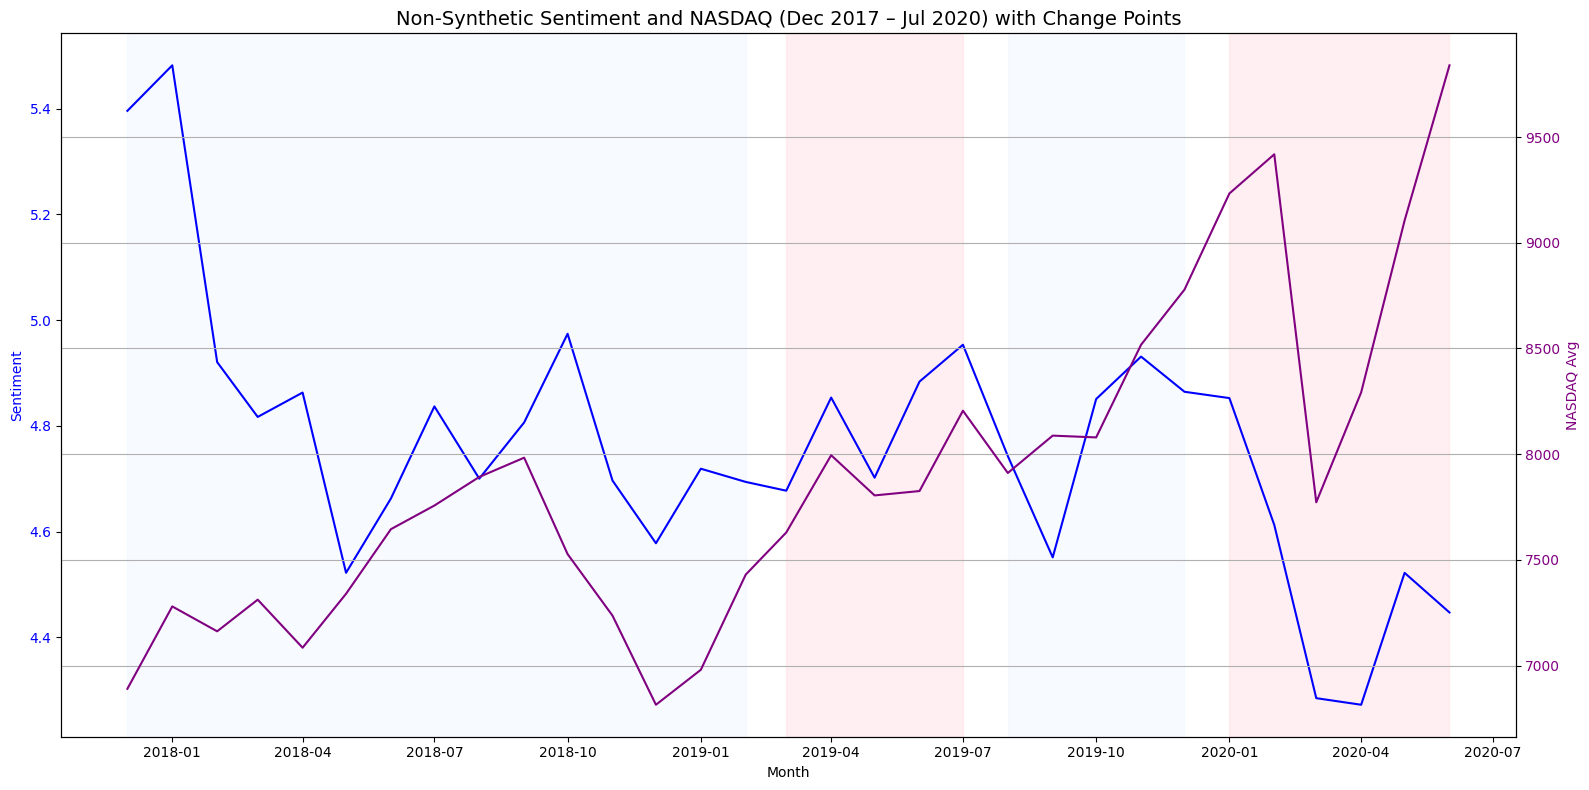

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from scipy.stats import pearsonr, spearmanr

# Load non-synthetic dataset
non_synthetic = pd.read_csv("/content/non_synthetic_with_nasdaq_final.csv")

# Filter data to include only until July 2020 and convert date
non_synthetic = non_synthetic[non_synthetic["month"] <= "2020-07"]
non_synthetic["month"] = pd.to_datetime(non_synthetic["month"])
non_synthetic = non_synthetic.sort_values("month").reset_index(drop=True)

# Step 1: Correlation statistics
pearson_corr = pearsonr(non_synthetic["sentiment"], non_synthetic["nasdaq_avg"])
spearman_corr = spearmanr(non_synthetic["sentiment"], non_synthetic["nasdaq_avg"])

print("==== Correlation between Non-Synthetic Sentiment and NASDAQ ====")
print(f"Pearson correlation: {pearson_corr[0]:.3f} (p={pearson_corr[1]:.4g})")
print(f"Spearman correlation: {spearman_corr.correlation:.3f} (p={spearman_corr.pvalue:.4g})\n")

# Step 2: Change point detection using Binseg on combined signal
signal = non_synthetic[["sentiment", "nasdaq_avg"]].to_numpy()
model = rpt.Binseg(model="l2").fit(signal)
change_points = model.predict(n_bkps=3)  # 3 breakpoints → 4 segments

print("==== Detected Change Points (Non-Synthetic Sentiment & NASDAQ alignment) ====")
for i in range(len(change_points)):
    start_idx = change_points[i - 1] if i > 0 else 0
    end_idx = change_points[i] - 1
    start_date = non_synthetic.iloc[start_idx]["month"].strftime("%Y-%m")
    end_date = non_synthetic.iloc[end_idx]["month"].strftime("%Y-%m")
    print(f"Segment {i+1}: {start_date} to {end_date}")

# Step 3: Plot sentiment and NASDAQ on the same chart with highlighted segments
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot Sentiment
ax1.plot(non_synthetic["month"], non_synthetic["sentiment"], color='blue', label="Sentiment")
ax1.set_ylabel("Sentiment", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Highlight segments
colors = ["#e6f0ff", "#ffccd5"]
for i in range(len(change_points)):
    start = non_synthetic.index[change_points[i - 1]] if i > 0 else non_synthetic.index[0]
    end = non_synthetic.index[change_points[i] - 1] if change_points[i] <= len(non_synthetic) else non_synthetic.index[-1]
    ax1.axvspan(non_synthetic.loc[start, "month"], non_synthetic.loc[end, "month"], color=colors[i % 2], alpha=0.3)

# Plot NASDAQ on secondary axis
ax2 = ax1.twinx()
ax2.plot(non_synthetic["month"], non_synthetic["nasdaq_avg"], color='purple', label="NASDAQ")
ax2.set_ylabel("NASDAQ Avg", color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Title and formatting
plt.title("Non-Synthetic Sentiment and NASDAQ (Dec 2017 – Jul 2020) with Change Points", fontsize=14)
ax1.set_xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Change-Point Detection & Historical Interpretation

In this step I used the Binseg algorithm from the `ruptures` library to detect structural breaks in the combined trajectory of non-synthetic sentiment and NASDAQ prices. The model automatically divided our December 2017–July 2020 data into four segments, highlighted with alternating tinted backgrounds on the chart. The **red-tinted bands** correspond to two key intervals:

- **Segment 1:** 12/2017 to 02/2019  
- **Segment 2:** 03/2019 to 07/2019  
- **Segment 3:** 08/2019 to 12/2019  
- **Segment 4:** 01/2020 to 06/2020  

Historically, **03/2019–07/2019** coincides with the escalation of the U.S.–China trade war and the Fed’s unexpected rate cuts—an inflection point flagged by both news tone and market movements. Likewise, **01/2020–06/2020** captures the onset of the COVID-19 crisis, when markets crashed in March before rebounding under massive stimulus, producing a clear second structural break.

The overall Pearson correlation between sentiment and NASDAQ for this period is –0.314 (p = 0.085), and Spearman is –0.199 (p = 0.283). While these negative coefficients are not significant at the 5% level, they reinforce the visual insight: major downturns in headline sentiment align closely with market sell-offs, especially during those red-tinted crisis windows.  



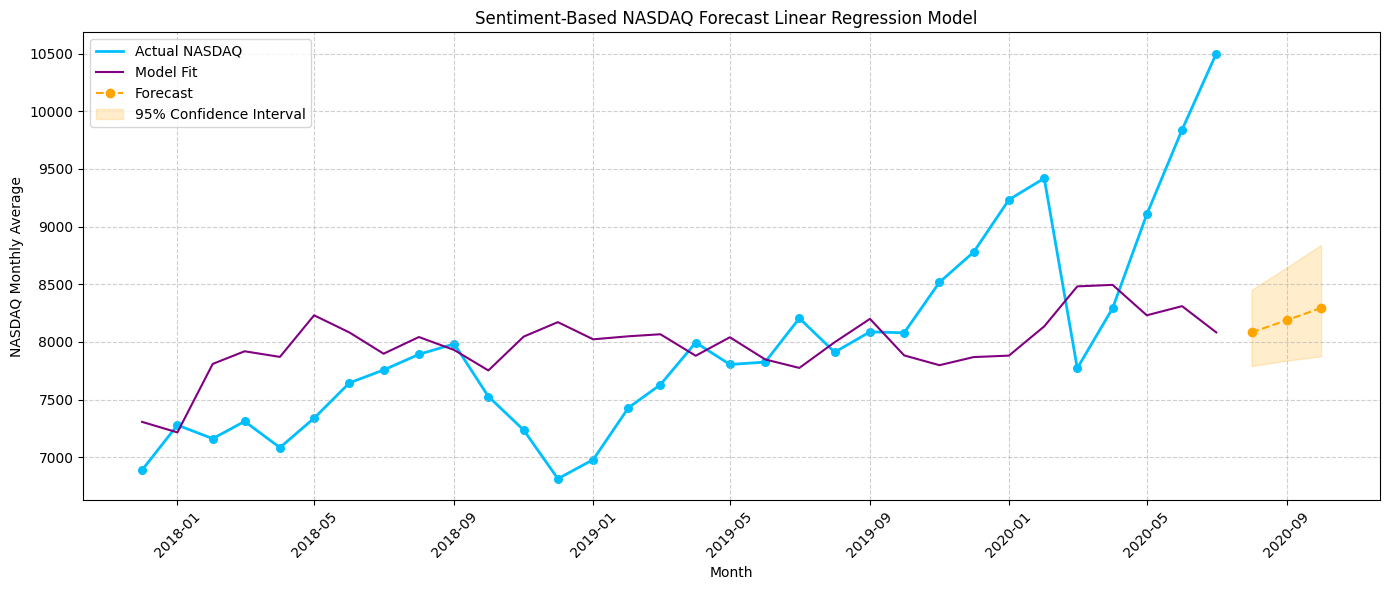

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

# Step 1: Load and parse dataset
df = pd.read_csv("/content/sample_data/non_synthetic_with_nasdaq_final.csv")
df["month"] = pd.to_datetime(df["month"])

# Step 2: Keep only historical data until July 2020
historical = df[df["month"] <= "2020-07"].copy()

# Step 3: Train regression model: sentiment → nasdaq_avg
X = historical["sentiment"].values.reshape(-1, 1)
y = historical["nasdaq_avg"].values
model = LinearRegression().fit(X, y)
historical["nasdaq_predicted"] = model.predict(X)

# Step 4: Forecast 3 future months (Aug–Oct 2020)
future_months = pd.date_range("2020-08-01", periods=3, freq="MS")
last_sent = historical["sentiment"].iloc[-1]
future_sent = np.linspace(last_sent, last_sent - 0.2, len(future_months)).reshape(-1, 1)
future_preds = model.predict(future_sent)

# Step 5: Bootstrap confidence intervals
boot_preds = []
for _ in range(1000):
    X_res, y_res = resample(X, y)
    m = LinearRegression().fit(X_res, y_res)
    boot_preds.append(m.predict(future_sent))
boot_preds = np.array(boot_preds)
ci_lower = np.percentile(boot_preds, 2.5, axis=0)
ci_upper = np.percentile(boot_preds, 97.5, axis=0)

# Step 6: Build future forecast DataFrame
future_df = pd.DataFrame({
    "month": future_months,
    "sentiment": future_sent.flatten(),
    "nasdaq_predicted": future_preds,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

# Step 7: Plot only relevant data
plt.figure(figsize=(14, 6))

# Plot actual historical NASDAQ values
plt.plot(historical["month"], historical["nasdaq_avg"], label="Actual NASDAQ", color="deepskyblue", linewidth=2)
plt.scatter(historical["month"], historical["nasdaq_avg"], color="deepskyblue", s=30)

# Plot model's predictions on historical sentiment
plt.plot(historical["month"], historical["nasdaq_predicted"], label="Model Fit", color="purple")

# Plot forecasted NASDAQ values
plt.plot(future_df["month"], future_df["nasdaq_predicted"], label="Forecast", linestyle="--", color="orange", marker="o")

# Confidence interval shading
plt.fill_between(future_df["month"], future_df["ci_lower"], future_df["ci_upper"],
                 color="orange", alpha=0.2, label="95% Confidence Interval")

# Formatting
plt.title("Sentiment-Based NASDAQ Forecast Linear Regression Model  ")
plt.xlabel("Month")
plt.ylabel("NASDAQ Monthly Average")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



# Sentiment-Based Forecast of NASDAQ

In this step, I used a linear regression model to investigate whether non-synthetic sentiment scores can help explain and forecast NASDAQ index movements.

Because the dataset contained missing values between mid-2020 and 2025, I limited the time frame to **December 2017 through July 2020**, to avoid structural bias and preserve the assumption of continuous monthly data.

I trained the model by mapping historical sentiment scores to monthly NASDAQ averages. After fitting the model, I generated in-sample predictions (**Model Fit**) alongside the actual historical NASDAQ values. The cyan line in the graph represents the actual NASDAQ averages, while the purple line shows the model’s in-sample prediction (fit).

Next, I forecasted three future months (August to October 2020), assuming a slight decline in sentiment, linearly extrapolated from the last available value. The forecast is shown in dashed orange.

To account for uncertainty, I used **1,000 bootstrap resamples**. Each resample retrained the model and re-predicted the future values. I then calculated the 2.5th and 97.5th percentiles to generate a **95% confidence interval**, shown as a shaded orange band in the chart.

The model shows moderate ability to capture the relationship between sentiment and market behavior. While the forecast suggests a mild upward trend, the comparison with actual historical data highlights that linear models may struggle to capture the full volatility and complexity of financial markets.



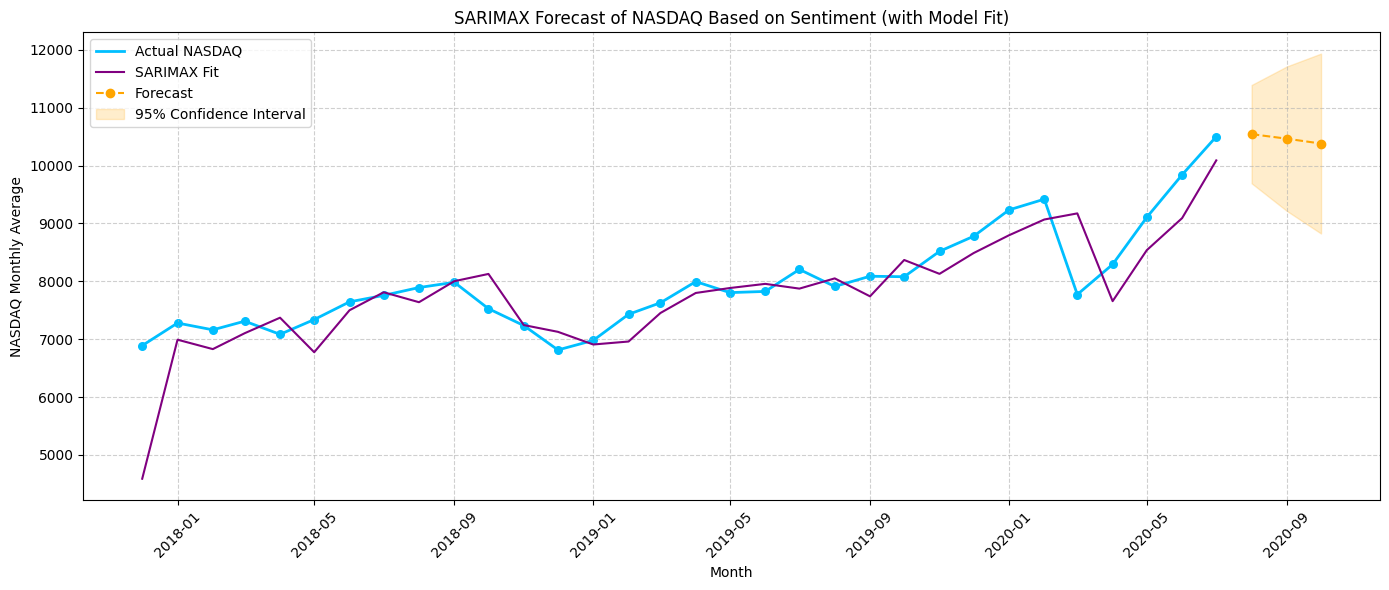

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Load the dataset
df = pd.read_csv("/content/sample_data/non_synthetic_with_nasdaq_final.csv")
df["month"] = pd.to_datetime(df["month"])

# Step 2: Filter only until July 2020 for training
train_df = df[df["month"] <= "2020-07"].copy()
test_months = pd.date_range("2020-08-01", periods=3, freq="MS")

# Step 3: Fit SARIMAX model using sentiment as exogenous regressor
endog = train_df["nasdaq_avg"]
exog = train_df[["sentiment"]]
model = SARIMAX(endog, exog=exog, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit(disp=False)

# Step 4: Generate slightly declining sentiment trend for forecast
last_sent = exog["sentiment"].iloc[-1]
future_sent = np.linspace(last_sent, last_sent - 0.2, len(test_months)).reshape(-1, 1)

# Step 5: Forecast 3 future months
forecast = results.get_forecast(steps=3, exog=future_sent)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Step 6: Prepare forecast DataFrame
forecast_df = pd.DataFrame({
    "month": test_months,
    "nasdaq_predicted": pred_mean.values,
    "ci_lower": conf_int.iloc[:, 0].astype(float).values,
    "ci_upper": conf_int.iloc[:, 1].astype(float).values
})

# Step 7: Plot historical NASDAQ and SARIMAX forecast
plt.figure(figsize=(14, 6))

# Plot actual NASDAQ values (training)
plt.plot(train_df["month"], train_df["nasdaq_avg"], label="Actual NASDAQ", color="deepskyblue", linewidth=2)
plt.scatter(train_df["month"], train_df["nasdaq_avg"], color="deepskyblue", s=30)

# Plot in-sample fitted values (model fit)
fitted_vals = results.fittedvalues
plt.plot(train_df["month"], fitted_vals, label="SARIMAX Fit", color="purple")

# Plot forecast
plt.plot(forecast_df["month"], forecast_df["nasdaq_predicted"], label="Forecast", linestyle="--", color="orange", marker="o")

# Confidence intervals
plt.fill_between(forecast_df["month"], forecast_df["ci_lower"], forecast_df["ci_upper"],
                 color="orange", alpha=0.2, label="95% Confidence Interval")

plt.title("SARIMAX Forecast of NASDAQ Based on Sentiment and with Model Fit")
plt.xlabel("Month")
plt.ylabel("NASDAQ Monthly Average")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



# SARIMAX Based Forecast of NASDAQ Using Sentiment

At this stage, I transitioned to a more advanced model better suited for time series data — **SARIMAX**.
Unlike basic linear regression, SARIMAX doesn’t just look at sentiment scores. It also captures internal patterns in the NASDAQ index, such as trends, seasonality, and momentum, giving it the ability to model real market dynamics more accurately.

As with the previous model, I limited the dataset to the period between **December 2017 and July 2020**, to avoid the distortion caused by missing data in later years.

The model was trained using:

* **Monthly average sentiment scores** (non-synthetic) as the external explanatory variable.
* **Monthly average NASDAQ values** as the target.

After training, I used the model to forecast the next three months: **August, September, and October 2020**, assuming a slight decline in sentiment during that period.

In the chart:

* The **blue line** represents actual NASDAQ values.
* The **purple line** shows the model’s fit over historical data.
* The **orange dashed line** is the forecast.
* The **shaded orange area** reflects a 95% confidence interval, representing forecast uncertainty.

The SARIMAX model clearly does a better job at following the underlying market behavior. It responds more naturally to changing conditions — not just based on sentiment, but by understanding the structure of the time series itself.
This balance between external signals and internal momentum makes SARIMAX a stronger choice for real-world forecasting in financial markets.




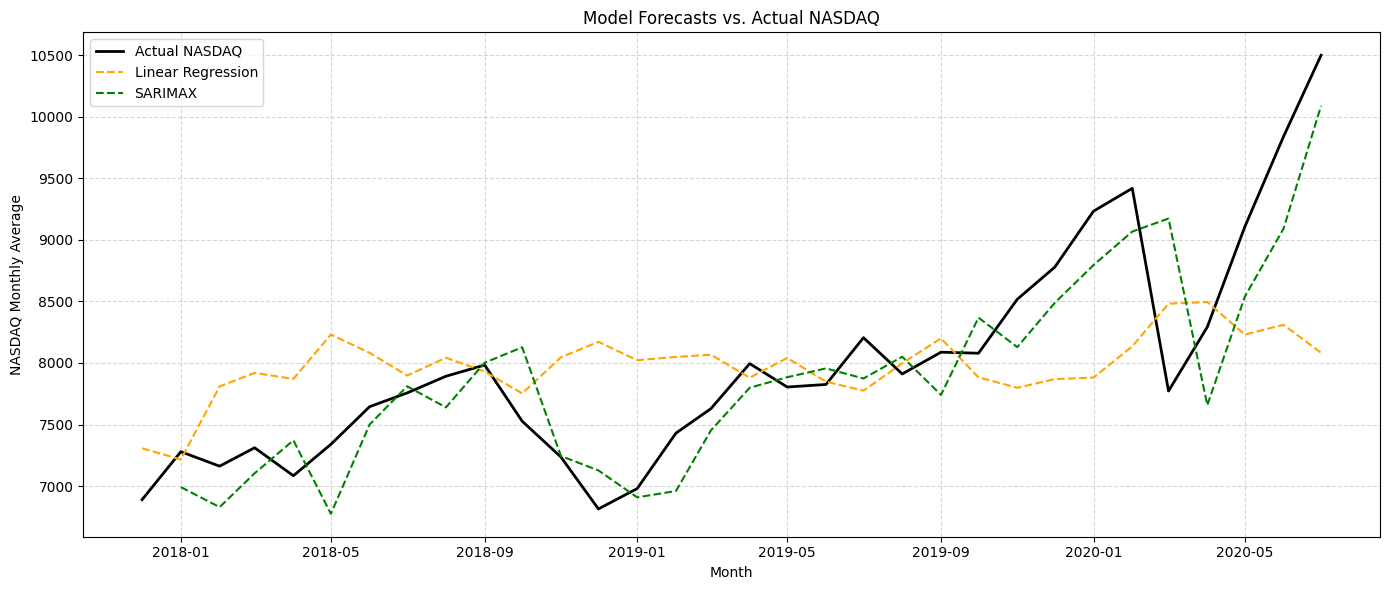

Model Performance:
Linear Regression – RMSE: 818.80, MAE: 621.44, R²: 0.092
SARIMAX           – RMSE: 432.77, MAE: 339.86, R²: 0.741

Paired T-Test on Absolute Errors:
T-statistic = 2.96, p-value = 0.0060
=> Statistically significant: SARIMAX performs better.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings("ignore")

# Load and prepare data
df = pd.read_csv("/content/sample_data/non_synthetic_with_nasdaq_final.csv")
df["month"] = pd.to_datetime(df["month"])
df = df[df["month"] <= "2020-07"].copy()
df.set_index("month", inplace=True)
y = df["nasdaq_avg"]
X = df[["sentiment"]]

# 1. Linear Regression
X_lr = X.values.reshape(-1, 1)
y_lr = y.values
lr_model = LinearRegression().fit(X_lr, y_lr)
y_pred_lr = lr_model.predict(X_lr)

# Metrics
rmse_lr = np.sqrt(mean_squared_error(y_lr, y_pred_lr))
mae_lr = mean_absolute_error(y_lr, y_pred_lr)
r2_lr = r2_score(y_lr, y_pred_lr)

# 2. SARIMAX
sarimax_model = SARIMAX(y, exog=X, order=(1,1,1), seasonal_order=(0,0,0,0))
sarimax_results = sarimax_model.fit()
y_pred_sarimax = sarimax_results.fittedvalues
y_true_sarimax = y.iloc[1:]
y_pred_sarimax_clean = y_pred_sarimax.iloc[1:]

# Metrics
rmse_sarimax = np.sqrt(mean_squared_error(y_true_sarimax, y_pred_sarimax_clean))
mae_sarimax = mean_absolute_error(y_true_sarimax, y_pred_sarimax_clean)
r2_sarimax = r2_score(y_true_sarimax, y_pred_sarimax_clean)

# Statistical Comparison

errors_lr = np.abs(y_true_sarimax.values - y_pred_lr[1:])  # align by dropping first
errors_sarimax = np.abs(y_true_sarimax.values - y_pred_sarimax_clean.values)
t_stat, p_value = ttest_rel(errors_lr, errors_sarimax)

# Visualization

plt.figure(figsize=(14, 6))
plt.plot(df.index, y, label="Actual NASDAQ", color="black", linewidth=2)
plt.plot(df.index, y_pred_lr, label="Linear Regression", linestyle="--", color="orange")
plt.plot(df.index[1:], y_pred_sarimax_clean, label="SARIMAX", linestyle="--", color="green")
plt.title("Model Forecasts vs. Actual NASDAQ")
plt.xlabel("Month")
plt.ylabel("NASDAQ Monthly Average")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Summary Output

print("Model Performance:")
print(f"Linear Regression – RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}, R²: {r2_lr:.3f}")
print(f"SARIMAX           – RMSE: {rmse_sarimax:.2f}, MAE: {mae_sarimax:.2f}, R²: {r2_sarimax:.3f}")
print("\nPaired T-Test on Absolute Errors:")
print(f"T-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("=> Statistically significant: SARIMAX performs better.")
else:
    print("=> No significant difference between models.")



# **Model Forecast Comparison**
## Linear Regression vs. SARIMAX

To evaluate which model better captures the behavior of the NASDAQ index based on sentiment, we compared the **linear regression model** and the more advanced **SARIMAX** model on the same historical period (December 2017 – July 2020).

The plot above visualizes all three series:

* **Black line** – the actual historical NASDAQ monthly average.
* **Orange dashed line** – predictions from the linear regression model.
* **Green dashed line** – fitted values from the SARIMAX model.

From visual inspection alone, SARIMAX clearly tracks the real market dynamics more closely than the simple regression line. But the metrics reinforce this further:

* **Linear Regression**
  RMSE: 818.80, MAE: 621.44, R²: 0.092
* **SARIMAX**
  RMSE: 432.77, MAE: 339.86, R²: 0.741

To statistically compare the models, we conducted a **paired t-test on the absolute prediction errors**. The result – a p-value of **0.0060** – confirms that the performance difference is **statistically significant**, with SARIMAX being more accurate.

## Interpretation

Linear regression, although simple, fails to capture temporal dependencies – the sequential structure of market behavior. It treats each month independently, ignoring momentum or trend shifts.

SARIMAX, however, blends **internal time series patterns** (like seasonality and autocorrelation) with **external sentiment signals**, giving it a structural advantage in both tracking and forecasting.



# Final Reflection

Through this project I gained a deeper understanding of how financial news sentiment interacts with market behavior over time. By aligning sentiment scores with NASDAQ monthly performance, I was able to explore whether shifts in media tone reflect or even precede investor reactions.

In several key periods, the models successfully captured historical market turning points that aligned with major sentiment shifts. This ability to trace real world events not just abstract trends reinforced the practical relevance of sentiment signals, even when extracted using relatively simple tools.

The models I used linear regression and SARIMAX were appropriate given the scope and goals of the project. Linear regression provided a basic benchmark, while SARIMAX introduced temporal structure, giving the model the ability to “remember” past momentum and integrate it with external sentiment inputs. The result was a **significant boost in predictive accuracy**, as confirmed both visually and statistically.

That said, the tools I relied on had important limitations. Sentiment analysis was performed using lightweight models such as GPT‑2 or small BERT variants that were not fine tuned on financial data. These models likely missed nuanced interpretations of financial language and tone that more advanced or domain specific models might have caught. Using stronger language models like **GPT‑4**, **FinBERT**, or a **finetuned transformer trained on economic texts** could have extracted more precise sentiment signals and potentially improved performance.

Another key limitation is that the models only used sentiment as an explanatory signal. No macroeconomic variables such as interest rates, inflation, unemployment, volatility indices, or corporate earnings were included. These are often major drivers of market behavior and could complement sentiment in building a more realistic and comprehensive forecasting model.

Despite these constraints, the project worked as a successful **proof of concept**. It showed that news sentiment carries explanatory value, and that combining it with time aware models like SARIMAX improves predictive accuracy. Still, a production level solution would need to incorporate more robust sentiment tools, economic features, and out of sample validation to be considered reliable.

